##  SolverFinal: <br>
- version: 1_8 <br>
It constructs initial condition using StabilityPartOnly, uses  finite difference methods of second order accuracy in space and first order accuracy in time to solve the Kawhara $u_t=\alpha u_{3x} + \beta u_{5x} + 2\sigma uu_x + cu_x$ using fsolve and outputs the solution in an animation
<br>
- version summary :
    - Documented
    - Initial condition imported from StabilityPartOnly
    - Uses padding for boundary conditions
<br>


In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as ss


import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline

from math import *

import scipy.optimize as so
from scipy.optimize import fsolve
from scipy import sparse

from scipy.sparse import diags 
from mpmath import findroot, atanh

In [2]:
%store -r Coeffs
%store -r mu1
%store -r mu2
%store -r L1
%store -r L2
%store -r vec1
%store -r vec2
%store -r M
%store -r V


In [22]:
print(M)
# mu1,mu2,L1,L2,vec1,vec2,M,V

10


In [139]:

L=2*np.pi # period




tFinal=0.7

nx=55
dx=L/(nx-1)
x = np.linspace(0,L,nx) # define space
dt = 0.001 # defining mesh grid width for space
nt = int(np.round(tFinal/dt) +1) # number of time steps
t = np.linspace(0,tFinal,nt) # define time


### parameters ###

alpha=1
beta=1/4
sigma=1
Gamma=0 #Damping coefficient
Forcing=0 #Forcing coefficient: Put 0,1,2
Kappa=1
Omega=1
aA=1

c= V #change to V

parameters=[['alpha',alpha],['beta',beta],['sigma',sigma]]


In [140]:
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)
#0.008 = dt(nx-1)/L

nx is: 55 dx is: 0.11635528346628864
nt is: 701 dt is 0.001
ratio dt/dx is 0.008594366926962348


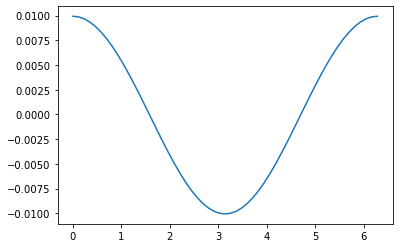

In [141]:
### Initial condition ### 
ufull=np.zeros([nx,nt])
Sumx=np.zeros(x.shape)
Sumx2=np.zeros(x.shape)
mu=-mu1
Lamb=L1
vec=vec1
delta=0.2
#constucting u_0

u_0 = Coeffs[0]*np.cos(0.*x)
for f in range(1,len(Coeffs)):
    u_0 = u_0 + Coeffs[f]*np.cos((f)*x) 

# rescaling to get zero average
u_0 = u_0 - Coeffs[0]
plt.plot(x,u_0)


/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/ipykernel_4628/3222910937.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  h_m1[mm]=(np.exp(m*i*1j))*vec1[mm]*(np.exp(mu1*i*1j))
/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/ipykernel_4628/3222910937.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  h_m2[mm]=(np.exp(m*i*1j))*vec2[mm]*(np.exp(mu2*i*1j)) #stable
/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/ipykernel_4628/3222910937.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  ufull[:,0]=u


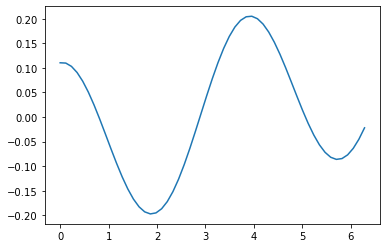

In [144]:
#constucting u_1
ii=0
for i in x:
    h_m1=np.zeros([(2*M)+1,1])
    h_m2=np.zeros([(2*M)+1,1])# Hm is the eigenvector with the largest real(lambda)
    mm=0
    for m in range(-M,M+1):
        h_m1[mm]=(np.exp(m*i*1j))*vec1[mm]*(np.exp(mu1*i*1j)) 
        h_m2[mm]=(np.exp(m*i*1j))*vec2[mm]*(np.exp(mu2*i*1j)) #stable
        mm+=1
    Sumx[ii]=sum(h_m1)
    Sumx2[ii]=sum(h_m2)

    
    ii+=1
    

u=u_0+delta*np.exp(L1)*Sumx 
u2=u_0+delta*np.exp(L2)*Sumx2 # the full initial condition

ufull[:,0]=u
# 1/1.5*np.cos(x)+1/(2*1.5)*np.cos(2*x)
plt.plot(x,ufull[:,0])
# plt.plot(x,u2)

## Function kawharafull <br>
Kawaharafull models Kawahara equation using finite difference methods of 2nd order accuracy in space and 1st order int time. $ 0=\frac{-1}{dt}(U-un)+\frac{\alpha}{dx^3}(-\frac{1}{2}uav_{i-2}+1uav_{i-1}-1uav_{i+1}+\frac{1}{2}uav_{i+2})+2\frac{\sigma}{dx}(-\frac{1}{2}uav_{i-1}+\frac{1}{2}uav_{i+1})(uav_{i})+c(-\frac{1}{2}uav_{i-1}+\frac{1}{2}uav_{i+1})+\frac{\beta}{dx^5}(-\frac{1}{2}uav_{i-3}+2uav_{i-2}-\frac{5}{2}uav_{i-1}+\frac{5}{2}uav_{i+1}-2uav{i+2}+\frac{1}{2}uav_{i+3})+\frac{\gamma}{dx^2}(1uav_{i-1}-2uav_{i}+1uav_{i+1})+forcing_{i-3} $ <br>
Crank Nicolson method has also been implemented by making every un an average with the unknown U. $uav=\frac{U+un}{2}$

## Input parameters:
- U: solution vector in space x at time t
- gamma: damping coefficient $\gamma u_{xx}$
- forcing: forcing term, it can take on the values of 0 (no forcing term), 1 ($A\cos(\kappa x-\omega t)$) and 2($A \omega t \cos(\kappa x)$)
- kappa, omega, A: driving force parameters, default values are set to 1. 

## Output parameters:
- Kawahara equations in form of $0=\alpha u_{3x} \beta u_{5x} + 2\sigma uu_x + cu_x - u_t$ that is nx long.<br>
<br>


In [145]:
### finite difference coefficients,2nd order accuracy ### 


def kawaharafull(U,gamma=Gamma,forcing=Forcing,kappa=Kappa,omega=Omega,A=aA):
   
    soln=np.zeros(nx,dtype='float64') 
    Upad=np.hstack((U[nx-4],U[nx-3],U[nx-2],U,U[1],U[2],U[3]))
    unpad=np.hstack((un[nx-4],un[nx-3],un[nx-2],un,un[1],un[2],un[3]))
    uavpad=1/2*(Upad+unpad)
    
    try:

        if forcing==0:
            forcing=np.zeros(nx,dtype='float64')
        elif forcing==1:
            forcing=A*np.cos(kappa*x-omega*time)
        elif forcing==2:
            forcing=A*omega*time*np.cos(kappa*x)
    except TypeError as e:
        print('Wrong')
        
        


    

    for i in range(3,nx+3):

        
        soln[i-3]=-1/dt*(Upad[i]-unpad[i])+alpha/(dx**3)*(-1/2*uavpad[i-2]+1*uavpad[i-1]-1*uavpad[i+1]+1/2*uavpad[i+2])+2*sigma/(dx)*(-1/2*uavpad[i-1]+1/2*uavpad[i+1])*(uavpad[i])+c*(-1/2*uavpad[i-1]+1/2*uavpad[i+1])+beta/dx**5*(-1/2*uavpad[i-3]+2*uavpad[i-2]-5/2*uavpad[i-1]+5/2*uavpad[i+1]-2*uavpad[i+2]+1/2*uavpad[i+3])+gamma/dx**2*(1*uavpad[i-1]-2*uavpad[i]+1*uavpad[i+1])+forcing[i-3]

        
  
    return soln
                                                                                                                 
                                                                                                           

In [146]:
# loop through times and use fsolve to solve the unknown vector U for every timestep
for n in range(1,nt): #for every time step
    time=(t[n]+t[n-1])/2 # update the time variable used in forcing 
    un = u.copy().real #copy existing values of u into un
    
    u=fsolve(kawaharafull, un,xtol=1.e-8)

    ufull[:,n]=u #nth time column
 


import os
os.system('say "your program has finished"')    

0

nt: 701 and dt: 0.001
nx: 55 and dx: 0.11635528346628864
[['alpha', 1], ['beta', 0.25], ['sigma', 1]]


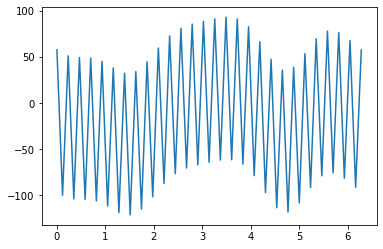

In [147]:
# plotting the final time
tFinal =nt-1

print('nt:',nt,'and dt:',dt)
print('nx:',nx,'and dx:',dx)
print(parameters)

plt.plot(x, ufull[:,tFinal])

nx is: 55 dx is: 0.11635528346628864
nt is: 701 dt is 0.001
ratio dt/dx is 0.008594366926962348


-84.98020638855085

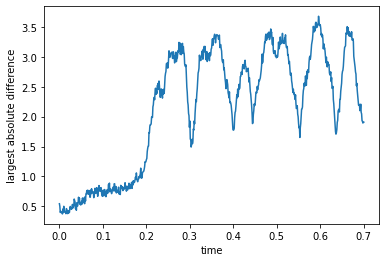

In [148]:
# This cell plots the biggest absolute difference in our solution for every time t and time t+1

growth=np.zeros((1,nt))
for time in range(nt-1):
    growth[0,time]=np.max(abs(ufull[:,time+1]-ufull[:,time]))
growth[0,nt-1]=growth[0,nt-2]    
plt.plot(t,growth.transpose())


plt.xlabel('time')
plt.ylabel('largest absolute difference')
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)

(np.log(growth[0,1])-np.log(growth[0,0]))/(t[1]-t[0]) # logarithmic slope

nx is: 55 dx is: 0.11635528346628864
nt is: 701 dt is 0.001
ratio dt/dx is 0.008594366926962348


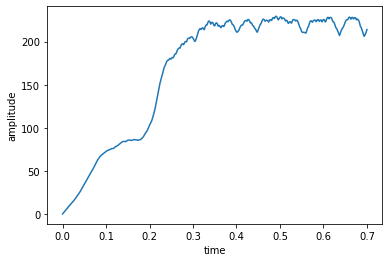

In [149]:
# for every time step, the largest difference in the solution is taken as amplitude and plotted over time
amp=np.zeros((1,nt))
for time in range(nt):
    amp[0,time]=np.max(np.max(ufull[:,time])-np.min(ufull[:,time]))

plt.plot(t,amp.transpose())


plt.xlabel('time')
plt.ylabel('amplitude')
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)


## Animation

In [150]:
from matplotlib import animation, rc
from IPython.display import HTML

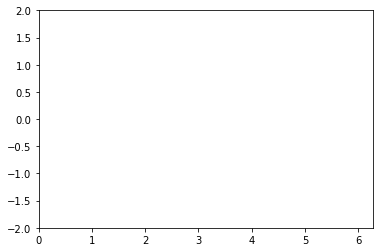

In [151]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, L))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])

    return (line,)

In [152]:
def animate(i):
    y=ufull[:,i*10]
    line.set_data(x,y,)
    
    return(line,)

In [153]:
# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)/10), interval=100) #frames is nt

In [154]:

HTML(anim.to_jshtml())
